<a href="https://colab.research.google.com/github/nh0875/Desafios-Procesamiento-del-Habla-974/blob/main/Copy_of_Desaf%C3%ADo_Final_Procesamiento_del_Habla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Desafio Obligatorio Procesamiento del Habla**
**Juan Ignacio Hilliard Bochaca 4162974**

**Tema 5 (Análisis de Sentimiento del Texto)**

Introduccion:

In [ ]:
!pip install transformers PyPDF2 pdfplumber torch

In [ ]:
# Importo las librerias como las dependencias que voy a usar en mi codigo
# Pdfplumber y re para procesar al Martin Fierro de forma correcta
import pdfplumber
import re
# Sklearn para dividir al Martin Fierro en Entrenamiento y Prueba
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import random

In [ ]:
# Filtrar el texto innecesario
def filtrar_texto(texto):
    # Uso "re" para que el bot no procese los numeros romanos al principio de cada pagina, como tambien el pie de las mismas
    texto_filtrado=re.sub(r'\b[I|V|X|L|C|D|M]+\b', '', texto)
    texto_filtrado=re.sub(r'\b(Página|Capítulo)\s?\d+\b', '', texto_filtrado)
    return texto_filtrado

# Dividir en estrofas
def obtener_estrofas(texto):
    lineas=[linea.strip() for linea in texto.split("\n") if linea.strip()]
    estrofas=[]
    i=0
    total_lineas=len(lineas)
    # Puse una condicion para la cantidad de Versos, todas las estrofas tienen 6 versos menos la ultima
    while i < total_lineas:
        # La ultima estrofa tiene 8 versos por eso puse una condicion en ella
        if total_lineas - i == 8:
            estrofa="\n".join(lineas[i:i + 8])
            estrofas.append(estrofa)
            i += 8
        # Estas serian todas las demas estrofas, 6 versos cada una
        else:
            estrofa="\n".join(lineas[i:i + 6])
            estrofas.append(estrofa)
            i += 6
    return estrofas

In [ ]:
# Uso pdfplumber para abrir el libro en mi entorno, aplico las funciones que cree lineas anteriores
with pdfplumber.open("/content/hernandez_jose_-_el_gaucho_martin_fierro.pdf") as pdf:
    text=""
    for page_num in range(3, len(pdf.pages)):  # Desde la página 4 comienza a procesar el texto
        page=pdf.pages[page_num]
        page_text=page.extract_text()
        if page_text:
            text += page_text + "\n"

# Filtrar y dividir en estrofas
text=filtrar_texto(text)
estrofas=obtener_estrofas(text)

In [ ]:
# Etiquetas simuladas para las estrofas
labels=[random.choice(['Positivo', 'Neutral', 'Negativo']) for _ in estrofas]

# Crear dataframe para mi texto
df=pd.DataFrame({'estrofa': estrofas, 'sentimiento': labels})

In [ ]:
# Inicializar el modelo y tokenizador usando BERT (dccuchile/bert-base-spanish-wwm-uncased) modelo pre-entrenado solo para procesar textoe n español
tokenizer=BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")
bert_model=BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

# Función para obtener embeddings de una frase
def obtener_embeddings(texto):
    tokens=tokenizer(texto, padding='max_length', truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        output=bert_model(**tokens)
    return output.last_hidden_state[:, 0, :].numpy()

# Vectorizar las estrofas, creo mi "X" y "y" para que mi bot precese el texto en partes
X=np.array([obtener_embeddings(estrofa)[0] for estrofa in df['estrofa']])
y=df['sentimiento'].map({'Positivo': 1, 'Neutral': 0, 'Negativo': -1}).values

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Separar conjuntos
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf=LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predicciones
y_pred=clf.predict(X_test)

# Visualizo las evaluaciones, use las metricas F-1 y Acurrancy
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Neutral', 'Positivo']))

Accuracy: 0.3974358974358974
Reporte de Clasificación:
              precision    recall  f1-score   support

    Negativo       0.53      0.37      0.43        27
     Neutral       0.33      0.36      0.35        22
    Positivo       0.37      0.45      0.41        29

    accuracy                           0.40        78
   macro avg       0.41      0.39      0.40        78
weighted avg       0.41      0.40      0.40        78



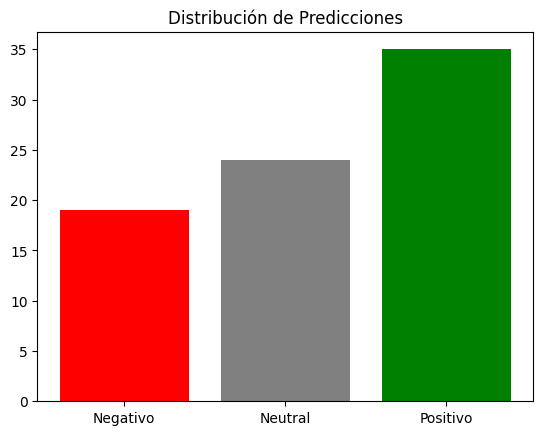

In [ ]:
# Graficos con las predicciones de mi modelo
unique, counts=np.unique(y_pred, return_counts=True)
plt.bar(['Negativo', 'Neutral', 'Positivo'], counts, color=['red', 'gray', 'green'])
plt.title("Distribución de Predicciones")
plt.show()